# SED fitting of grism spectroscopy with Grizli and Dynesty

## Ressources:
### Grizli: https://grizli.readthedocs.io/en/latest/

### Dynesty: https://dynesty.readthedocs.io/en/latest/

## This example notebook will showcase a practicle use-case of estimating galaxy physical parameters through the SED fitting of grism spectra using Grizli and the nested-sampling algorithm Dynesty.

# --
# Overview:
## 0 - The Imports
## 1 - Get the grism data generated by grizli
## 2 - Define the functions for the fitting and convergence
### &emsp;&emsp;&emsp;&emsp;A. Define Priors
### &emsp;&emsp;&emsp;&emsp;B. Define Likelihood function
### &emsp;&emsp;&emsp;&emsp;C. Definie Template function
### &emsp;&emsp;&emsp;&emsp;D. Define Fitting function
### &emsp;&emsp;&emsp;&emsp;E. Define Sampling function
## 3 - Run the fitting
## 4 - Look at the results

# --
## 0 - The imports

In [167]:
import os

import numpy as np
import astropy
from astropy.io import ascii, fits
from astropy import units as u
from astropy.table import Table, vstack, hstack
from astropy.cosmology import FlatLambdaCDM
from astropy.stats import bootstrap
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import fsps

import pathlib

import dynesty
from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

import grizli
from grizli.pipeline import auto_script
from grizli import utils, fitting, multifit, prep

import multiprocessing as mp
import multiprocessing.pool

import spectres

In [2]:
print("numpy", np.__version__) #1.18.4
print("astropy", astropy.__version__) #4.1
print("fsps", fsps.__version__) #0.3.0
print("dynesty", dynesty.__version__) #1.0.0
print("grizli", grizli.__version__) #1.0.dev1365

numpy 1.18.4
astropy 4.1
fsps 0.3.0
dynesty 1.0.0
grizli 1.0.dev1365


# --
# 1 - Get the grism data generated by grizli


## Directory Structure

In [285]:
!ls -l

total 16336
-rw-r--r--   1 gael  staff  8361797 10 Mar 12:58 grism2D_sed_fitting.ipynb
drwxr-xr-x  12 gael  staff      384 10 Mar 01:01 grizli_data


In [173]:
!ls -l grizli_data/*/

grizli_data/54021/:
total 36440
-rw-r--r--  1 gael  staff  9374400 23 Sep  2020 gds-grism-j033236m2748_54021_beams.fits
-rw-r--r--  1 gael  staff  7554240 23 Sep  2020 gds-grism-j033236m2748_54021_full.fits
-rw-r--r--  1 gael  staff   225985 23 Sep  2020 gds-grism-j033236m2748_54021_full.png
-rw-r--r--  1 gael  staff    38453 23 Sep  2020 gds-grism-j033236m2748_54021_line.png
-rw-r--r--  1 gael  staff  1160640 23 Sep  2020 gds-grism-j033236m2748_54021_stack.fits
-rw-r--r--  1 gael  staff   234981 23 Sep  2020 gds-grism-j033236m2748_54021_stack.png

grizli_data/54062/:
total 43640
-rw-r--r--  1 gael  staff  11401920 23 Sep  2020 gds-grism-j033236m2748_54062_beams.fits
-rw-r--r--  1 gael  staff   9276480 23 Sep  2020 gds-grism-j033236m2748_54062_full.fits
-rw-r--r--  1 gael  staff    189921 23 Sep  2020 gds-grism-j033236m2748_54062_full.png
-rw-r--r--  1 gael  staff     41075 23 Sep  2020 gds-grism-j033236m2748_54062_line.png
-rw-r--r--  1 gael  staff   1163520 23 Sep  2020 gds-grism-j03

## The data
The data consist of a star-forming source at z=0.98 and a quiescent source at z=1.22, both located in the GOODS-S field. (Taken from Noirot+2022).

# GRIZLI Source ID 54021
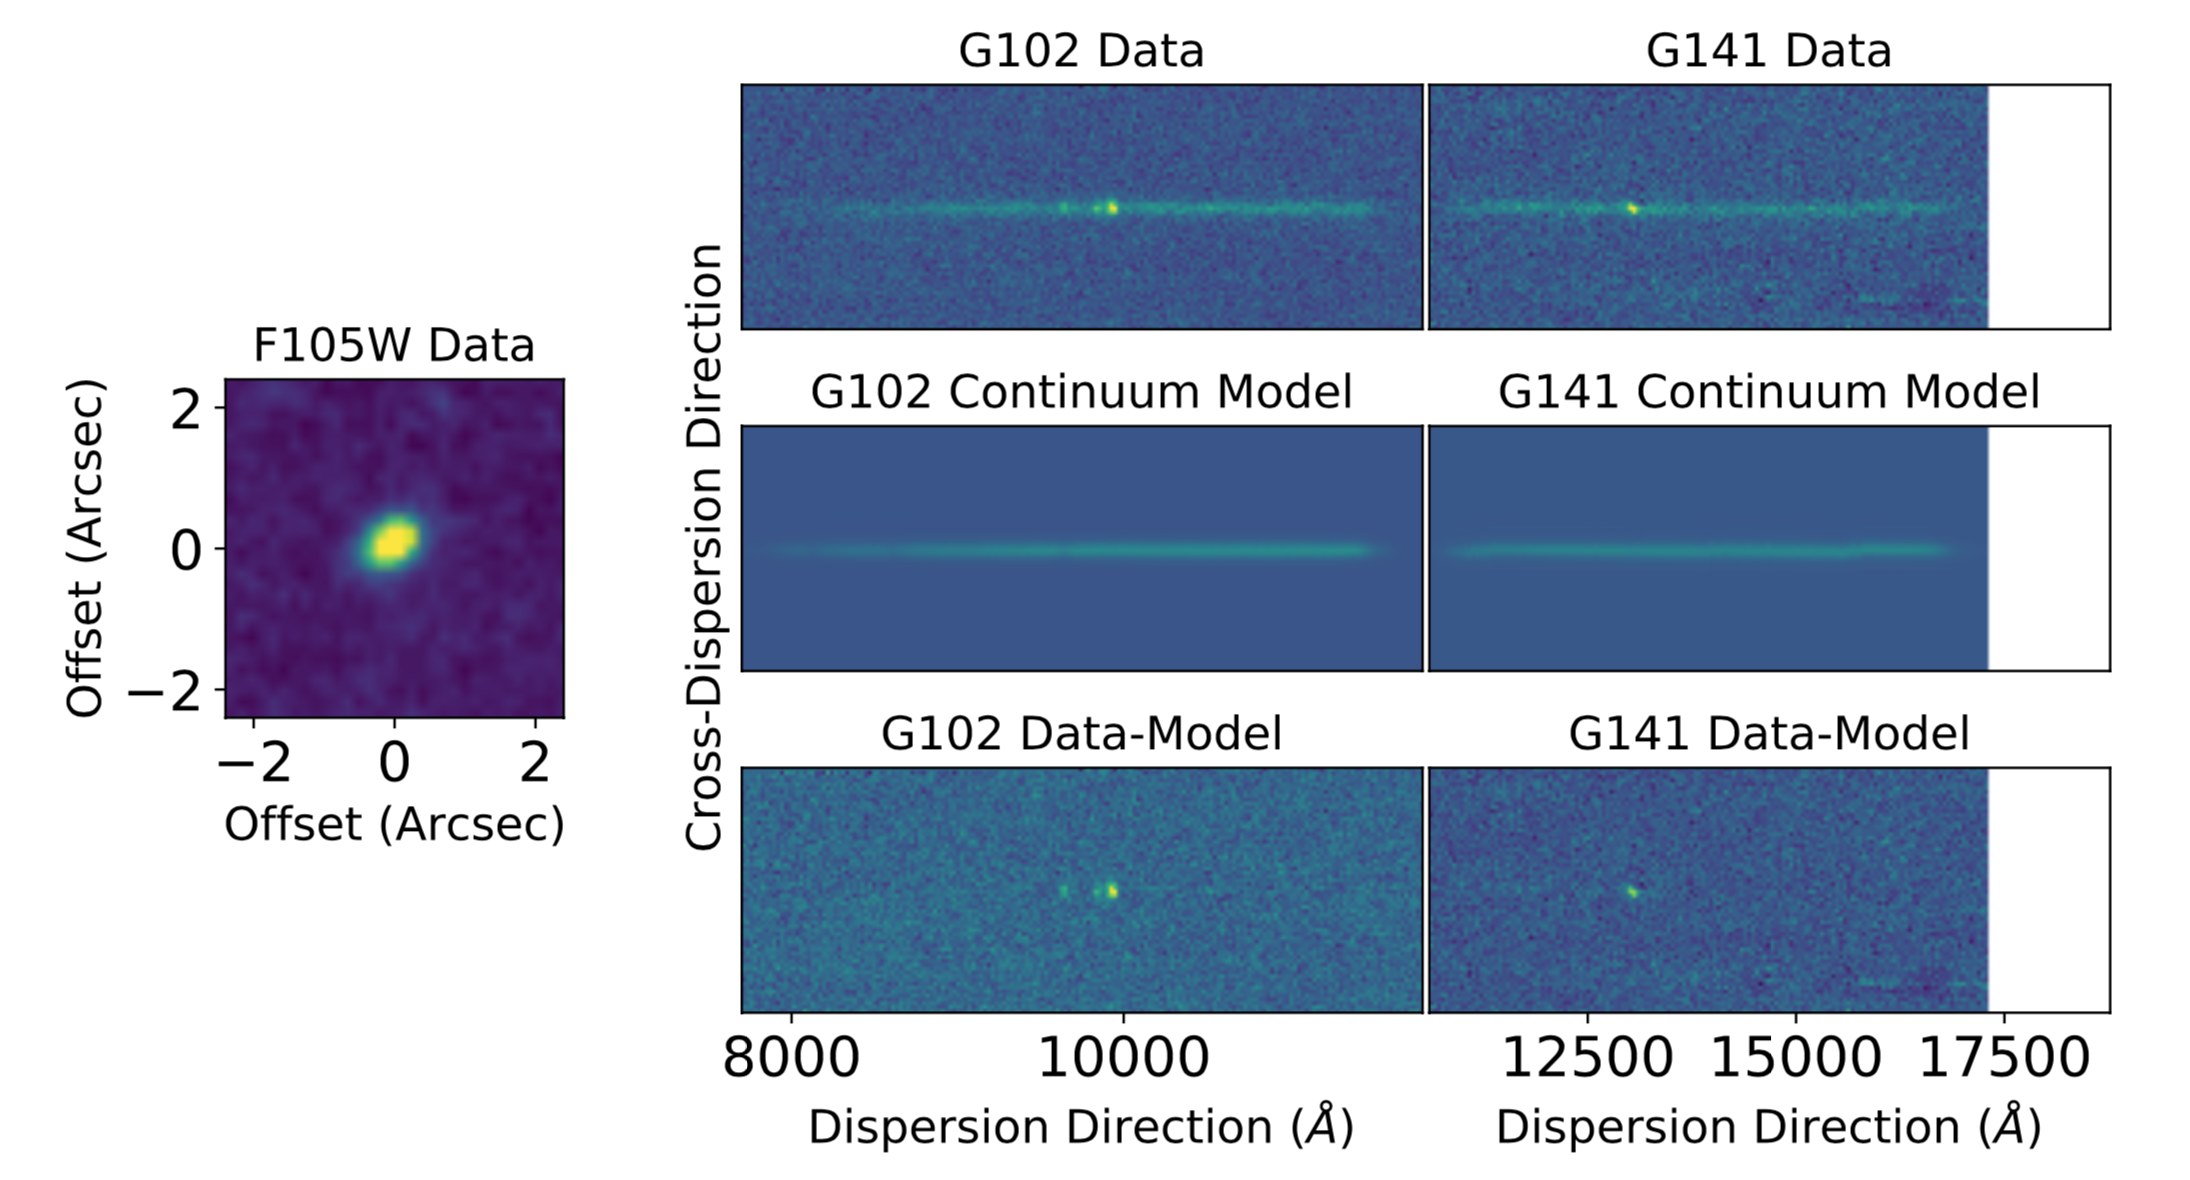

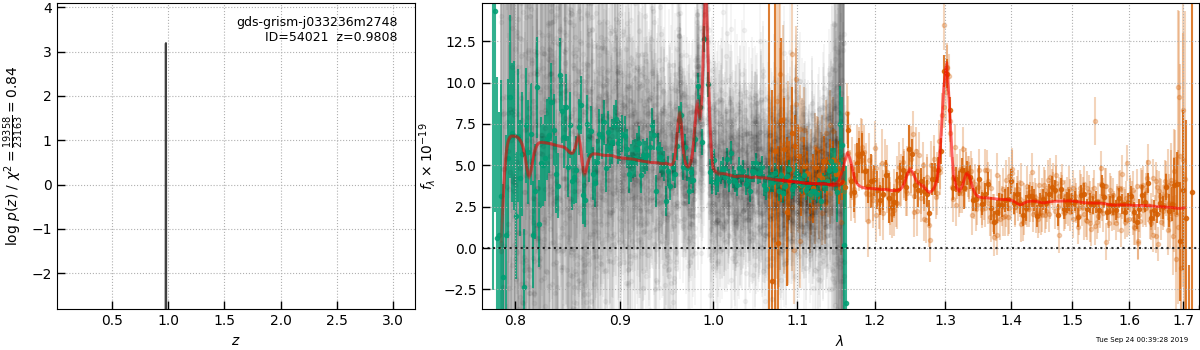

# GRIZLI Source ID 54062
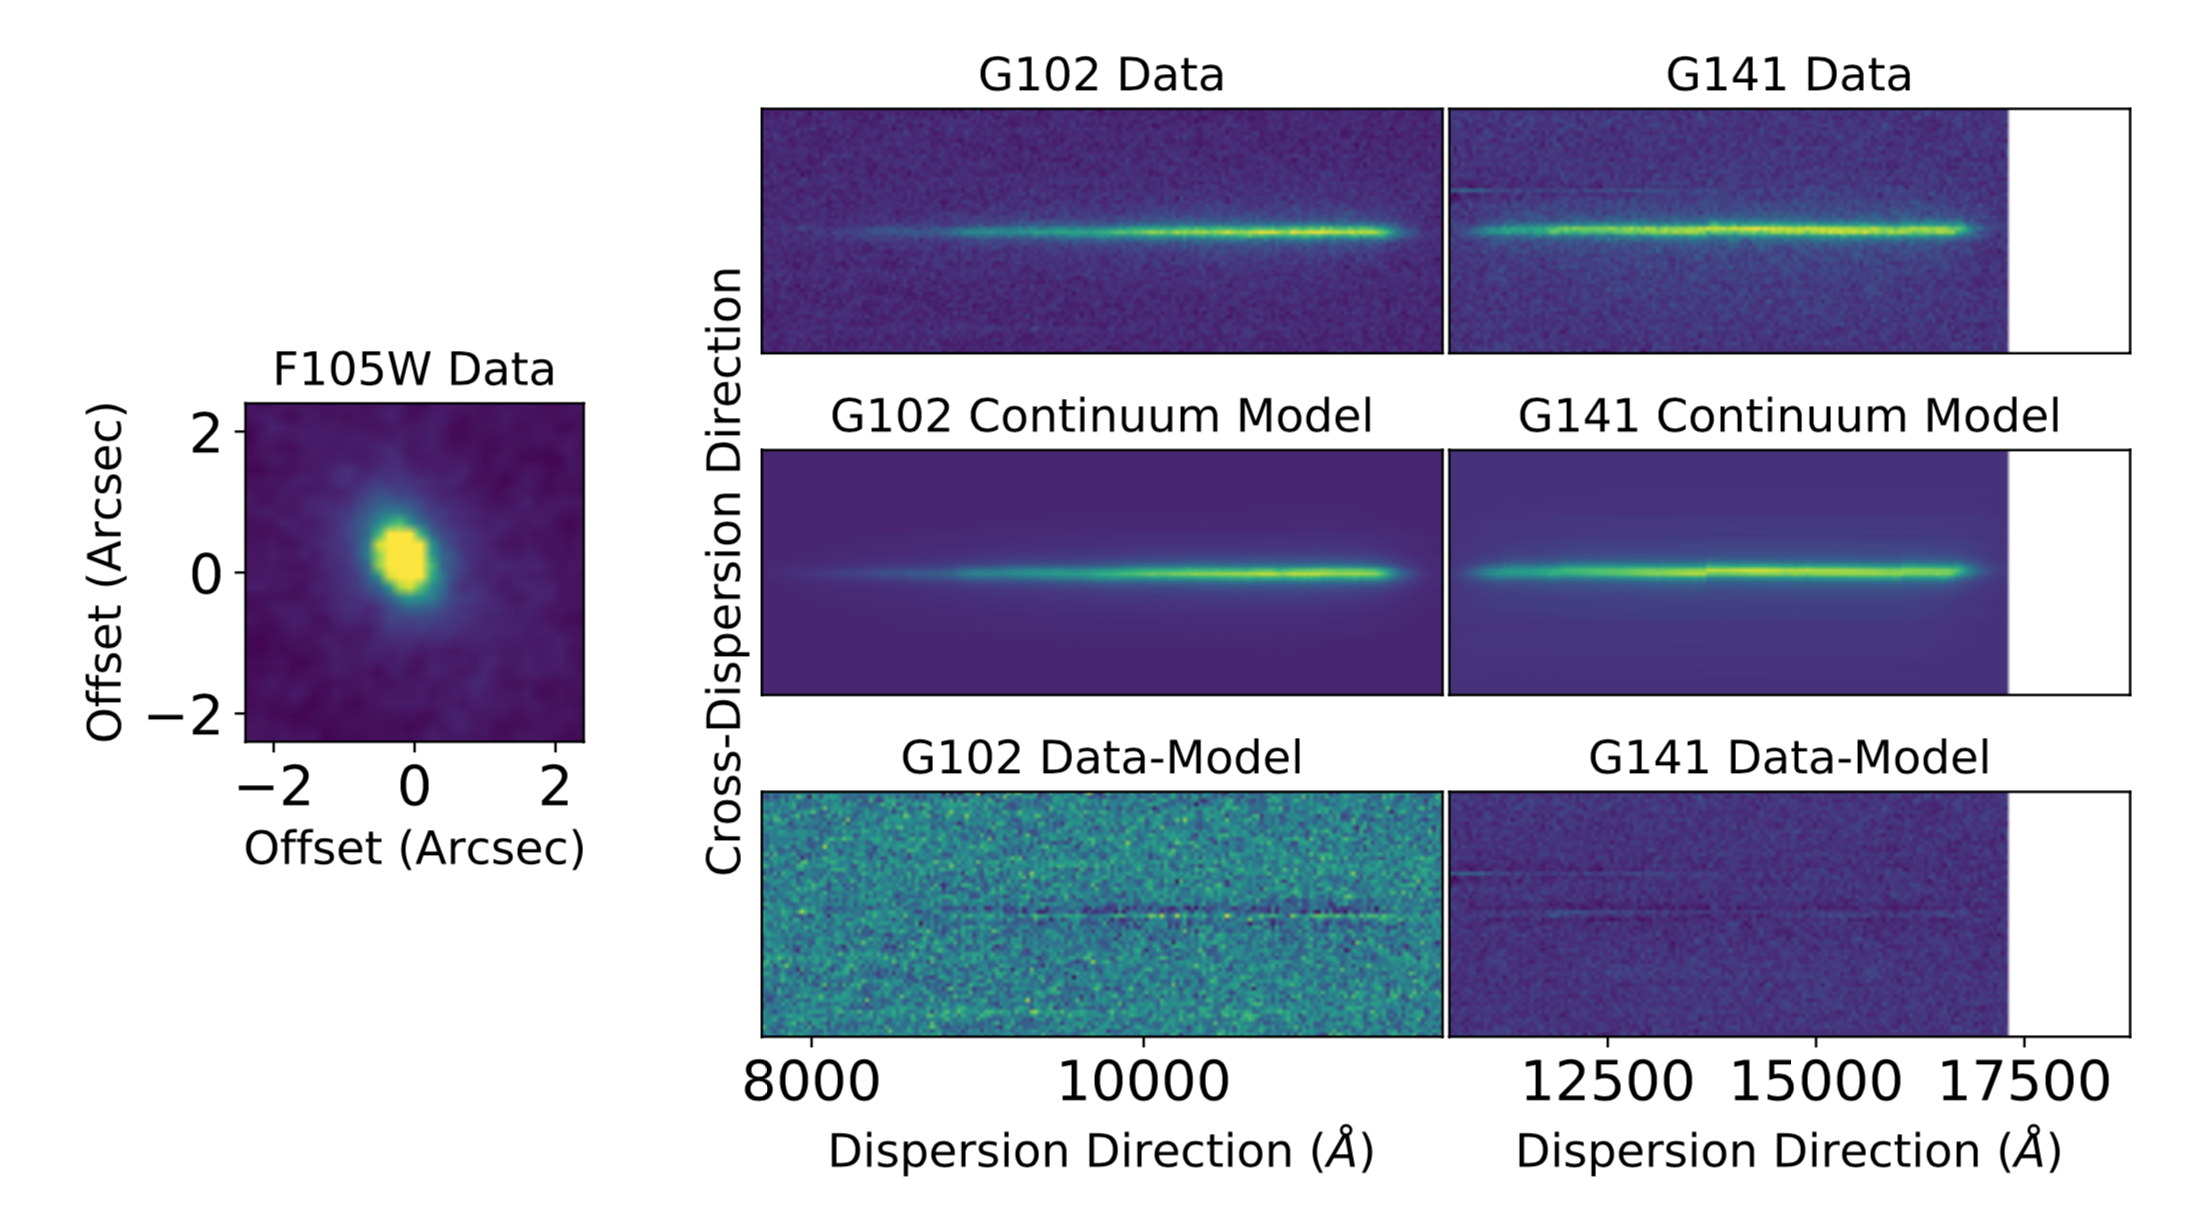

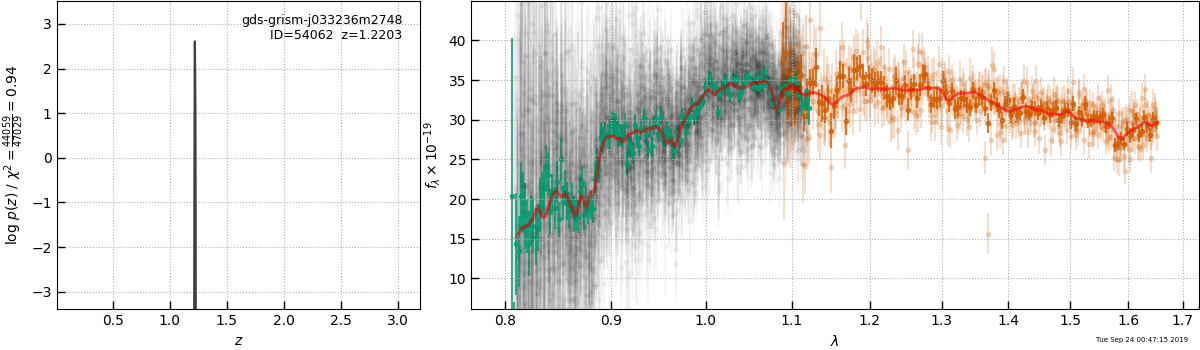

## Function that creates grizli multibeam object

In [3]:
def get_mbeam(path2beamfile, path2fullfile):
    
    ''' 
        path2beamfile
            path to grizli beams.fits file containing all relevant beam infos to perform fitting of a given source.

        path2fullfile
            path to grizli full.fits file containing all relevant infos from first-pass grizli fit


        returns
            mbeam, z50
    '''
    
    #load full.fits
    full = fits.open(path2fullfile)
    
    #get grizli redshift_50
    z50 = full[1].header['z50']
    
    #grizli multi-beam object
    mbeam = grizli.multifit.MultiBeam(beams=path2beamfile, fcontam=0.2, min_sens=0.01, sys_err=0.03)

    
    return mbeam, z50
    

# Use-case
## Get the multi-beam objects of the two grizli sources.

In [4]:
#select the sources
source_ID_sf = 54021
source_ID_q = 54062



#First: SF source
source_ID = source_ID_sf

#path to grizli beam data
path2beamfile = "grizli_data/"+str(source_ID)+"/gds-grism-j033236m2748_"+str(source_ID)+"_beams.fits"
path2fullfile = "grizli_data/"+str(source_ID)+"/gds-grism-j033236m2748_"+str(source_ID)+"_full.fits"

#get beam object and source redshift
mbeam_sf, z50_sf = get_mbeam(path2beamfile, path2fullfile)



#Second: Q source
source_ID = source_ID_q

#path to grizli beam data
path2beamfile = "grizli_data/"+str(source_ID)+"/gds-grism-j033236m2748_"+str(source_ID)+"_beams.fits"
path2fullfile = "grizli_data/"+str(source_ID)+"/gds-grism-j033236m2748_"+str(source_ID)+"_full.fits"

#get beam object and source redshift
mbeam_q, z50_q = get_mbeam(path2beamfile, path2fullfile)


load_master_fits: grizli_data/54021/gds-grism-j033236m2748_54021_beams.fits
1 ibhj30c6q_flt.fits G141
2 ibhj30cdq_flt.fits G141
3 ibhj30ckq_flt.fits G141
4 icxt13gfq_flt.fits G102
5 icxt13ghq_flt.fits G102
6 icxt13gkq_flt.fits G102
7 icxt13gmq_flt.fits G102
8 icxt14roq_flt.fits G102
9 icxt14rqq_flt.fits G102
10 icxt14rtq_flt.fits G102
11 icxt14rvq_flt.fits G102
12 icxt15emq_flt.fits G102
13 icxt15enq_flt.fits G102
14 icxt15esq_flt.fits G102
15 icxt15ewq_flt.fits G102
16 icxt17aiq_flt.fits G102
17 icxt17akq_flt.fits G102
18 icxt17anq_flt.fits G102
19 icxt17apq_flt.fits G102
20 icxt18ykq_flt.fits G102
21 icxt18ynq_flt.fits G102
22 icxt18zgq_flt.fits G102
23 icxt18zjq_flt.fits G102


/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/multifit.py:1579: RuntimeWarning: divide by zero encountered in true_divide
  ivar = 1./(1/b.ivar + (self.sys_err*sciu)**2)


load_master_fits: grizli_data/54062/gds-grism-j033236m2748_54062_beams.fits
1 ibhj11hiq_flt.fits G141


/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:3578: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


2 ibhj11hpq_flt.fits G141
3 ibhj11hwq_flt.fits G141
4 ibhj11i3q_flt.fits G141
5 icxt30s0q_flt.fits G102
6 icxt30s2q_flt.fits G102
7 icxt30s5q_flt.fits G102
8 icxt30s7q_flt.fits G102
9 icxt31r1q_flt.fits G102
10 icxt31r3q_flt.fits G102
11 icxt31r6q_flt.fits G102
12 icxt31r8q_flt.fits G102
13 icxt32nlq_flt.fits G102
14 icxt32nmq_flt.fits G102
15 icxt32npq_flt.fits G102
16 icxt32nrq_flt.fits G102
17 icxt33roq_flt.fits G102
18 icxt33rpq_flt.fits G102
19 icxt33rsq_flt.fits G102
20 icxt33ruq_flt.fits G102
21 icxt34ekq_flt.fits G102
22 icxt34emq_flt.fits G102
23 icxt34epq_flt.fits G102
24 icxt34erq_flt.fits G102
25 icxt35s4q_flt.fits G102
26 icxt35s6q_flt.fits G102
27 icxt35s9q_flt.fits G102
28 icxt35sbq_flt.fits G102


/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:640: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:641: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3219: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3251: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.d

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:640: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:641: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3219: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3251: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.d

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:640: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:641: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3219: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3251: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.d

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:641: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3219: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3251: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:640: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.d

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:641: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3219: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3251: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:640: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.d

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:641: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3219: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3251: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:640: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.d

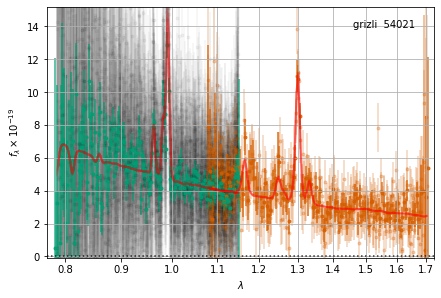

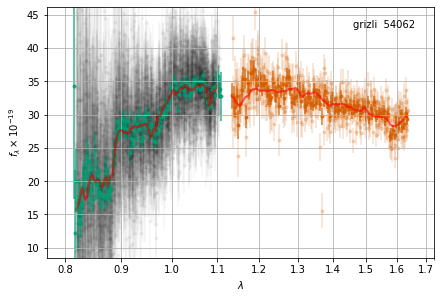

In [20]:
#Show grizli spectrum with grizli template fit.

#SF source
mbeam = mbeam_sf
z50 = z50_sf
fig_sf = mbeam.oned_figure(tfit=mbeam.template_at_z(z50))


#Q source
mbeam = mbeam_q
z50 = z50_q
fig_q = mbeam.oned_figure(tfit=mbeam.template_at_z(z50))

## --
## 2 - Define the functions for the fitting and convergence


Note: We will fit our data using FSPS templates (https://dfm.io/python-fsps/current/)  and delayed-tau SFH models.
Delayed-tau models are of the form: t * np.exp(-t/tau), where tau is the rising timescale.
The parameters we will fit are: age, tau, metallicity (Z), and dust.

Example of a delayed-tau model (from Noirot+2022)
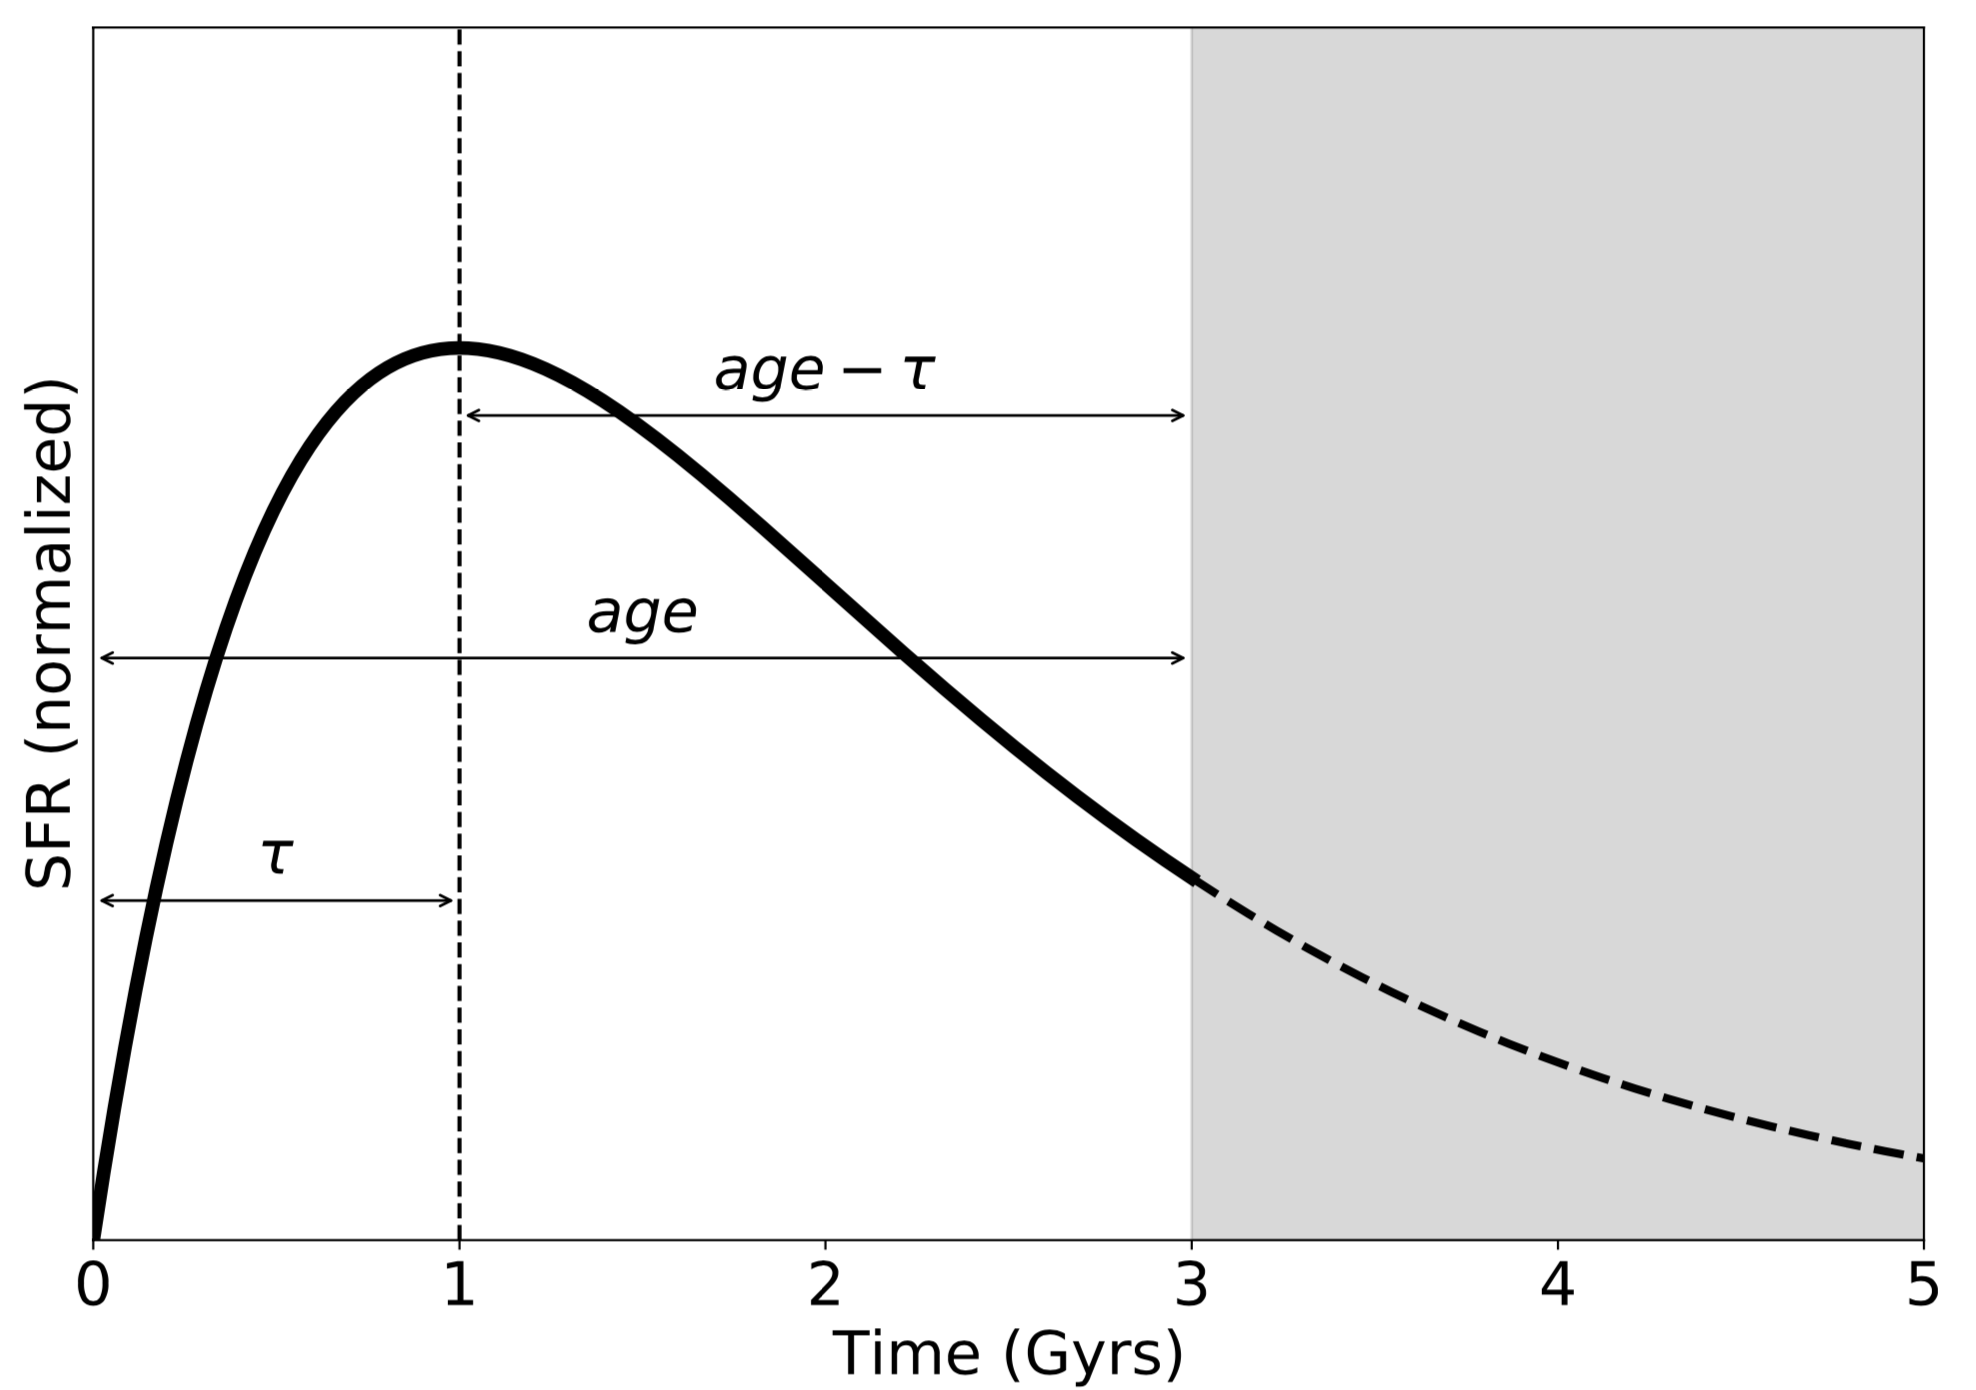

### &emsp;&emsp;&emsp;&emsp;A. Define Priors

In [281]:
def prior_transform(u):
    x = np.array(u)

    #Priors
    
    #get age of universe at z to use as source age upper limit
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    ageU_z = cosmo.age(redshift).value

    #age -> 0 to age_universe_at_z
    x[0] = u[0]*(ageU_z)
    
    #tau -> 0 to 6.0
    x[1] = u[1]*6.0
    
    #Z -> 0.00 to 3.0
    x[2] = u[2]*3.0
    
    ##Av 0 to 4.0
    x[3] = u[3]*4.0

    return x

### &emsp;&emsp;&emsp;&emsp;B. Define Likelihood function

In [22]:
#define log likelihood function given parameters and data.
def log_likelihood_func(x):

    #get model SED
    model = get_new_sed(x)
    
    #get tfit parameters from grizli
    tfit = fit_sed2grism(model, x)
    
    #get chi2
    chi2 = tfit['chi2']

    return (-chi2 / 2.)

### &emsp;&emsp;&emsp;&emsp;C. Definie Template function

In [280]:
#generate new model template from fsps
def get_new_sed(x):

    age, tau, Z, dust = x

    #update fsps
    sp.params['tau'] = tau
    sp.params['logzsol'] = np.log10(Z)
    sp.params['dust2'] = dust

    #FSPS returns spectrum in Lo/angstroms with Lo in sol_lum --> need to convert to flux densities f_lambda.
    #Spectrum is returned for 1Mo of mass formed (different from living stellar mass).
    wave, flux_Lumlamb = sp.get_spectrum(tage=age, peraa=True)
    model = (wave, flux_Lumlamb)

    return model

### &emsp;&emsp;&emsp;&emsp;D. Define Fitting function

In [284]:
#Fit template to grizli grism data using grizli built-in function template_at_z
def fit_sed2grism(model, x):
    
    age, tau, Z, dust = x

    #rest-frame model
    wave = model[0]
    flux = model[1]
    
    #flux conversion from Lsol/angstroms to f_lambda (rest-frame):
    dist_lum = 10 * 3.08567758128e19 #in cm
    sol_lum_to_ergs_sec = 3.826*10**33
    #according to fsps, flux is normalized for 1Mo of total mass_formed by tage,
    #so scaling by mass_formed should give properly scaled model flux
    #However grizli computes a scaling between the template and the spectrum
    #Template can be normalized to fixed mass, 
    #and actual mass can be derived using the grizli fit coefficient times this scaled version 
    #of the template (with appropriate unit conversion)
    #here use fixed mass of 1Mo formed
    scale_mass = 1
    flux = model[1] * scale_mass / ((4*np.pi*dist_lum**2)) * sol_lum_to_ergs_sec
    
    #generate rest-frame grizli template of the model
    my_griz_templ = {'templ': grizli.utils.SpectrumTemplate(wave=wave, flux=flux)}
    
    #grizli fitting
    tfit = mbeam_obj.template_at_z(redshift, templates=my_griz_templ, fit_background=True)
    
    return tfit


### &emsp;&emsp;&emsp;&emsp;E. Define Sampling function

In [37]:
def dyn_fitting(parameters, max_iter):
        
        #ndim
        ndim = len(parameters)
        
        #live points, should be at least > 50 as per doc. default = 250
        nlive_pts = 400
        
        #bounding option (none, single, multi, balls, cubes). default = multi
        bound_opt = 'multi'
        
        #sampling option (unif, rwalk, rstagger, slice, rslice, hslice). default = unif for ndim < 10.
        sampling_opt = 'unif'
        
        # initialize nested sampler
        sampler = NestedSampler(log_likelihood_func, prior_transform, ndim, nlive=nlive_pts, bound=bound_opt, sample=sampling_opt)

        #running sampler
        #stop when reach a given number of iterations (will stop before if converged)
        max_iter = max_iter
        
        #run
        sampler.run_nested(maxiter=max_iter)
        
        #results
        dyn_results = sampler.results
        dyn_results.summary()
        
        #samples
        samples = dyn_results['samples']
        weights = np.exp(dyn_results['logwt'] - dyn_results['logz'][-1])
        
        #weighted samples
        samples_equal = dyfunc.resample_equal(samples, weights)
        
        return dyn_results, samples, samples_equal

## 3 - Run the fitting
### &emsp;A. Fit the SF source using the source's grizli multibeam object previously imported

In [38]:
#Define parameters
global mbeam_obj, sp, redshift

#max number of iterations in dynesty
max_iter = 6500

#define parameters
parameters = ['age', 'tau', 'Z', 'dust']


In [39]:
#instanciate FSPS stellar pop

#sfh=4 --> delayed tau model.
#dust_type=2 --> Calzetti dust law.

sp = fsps.StellarPopulation(compute_vega_mags=False, sfh=4, zcontinuous=1, dust_type=2, add_neb_emission=1)


In [40]:
#Call fitting function on SF source

#SF multibeam object
mbeam_obj = mbeam_sf

#SF source redshift
redshift = z50_sf

dyn_results_sf, samples_sf, samples_equal_sf = dyn_fitting(parameters=parameters, max_iter=max_iter)



3235it [30:01,  1.80it/s, +400 | bound: 11 | nc: 1 | ncall: 20853 | eff(%): 17.432 | loglstar:   -inf < -9498.378 <    inf | logz: -9505.507 +/-  0.179 | dlogz:  0.001 >  0.409]


Summary
nlive: 400
niter: 3235
ncall: 20853
eff(%): 17.432
logz: -9505.507 +/-  0.179


In [263]:
#save results
if False:
    np.save('dyn_results_sf.npy', dyn_results_sf)
    np.save('samples_sf.npy', samples_sf)
    np.save('samples_equal_sf.npy', samples_equal_sf)

In [264]:
#load
if True:
    dyn_results_sf = np.load('dyn_results_sf.npy', allow_pickle=True)
    samples_sf = np.load('samples_sf.npy', allow_pickle=True)
    samples_equal_sf = np.load('samples_equal_sf.npy', allow_pickle=True)

In [265]:
#Quick look at results
posterior_percentiles = np.nanpercentile(samples_equal_sf, [16, 50, 84], axis=0).T
posterior_percentiles

array([[1.88717923, 2.27845214, 2.69913822],
       [2.20452741, 3.91403274, 5.35600096],
       [2.20326903, 2.66189491, 2.91211906],
       [0.19596832, 0.30165315, 0.40067719]])

### &emsp;B. Fit the Q source using the source's grizli multibeam object previously imported

In [68]:
#Call fitting function on Q source

#SF multibeam object
mbeam_obj = mbeam_q

#SF source redshift
redshift = z50_q

dyn_results_q, samples_q, samples_equal_q = dyn_fitting(parameters=parameters, max_iter=max_iter)



5104it [1:10:29,  1.21it/s, +400 | bound: 19 | nc: 1 | ncall: 25373 | eff(%): 21.692 | loglstar:   -inf < -20528.533 <    inf | logz: -20540.357 +/-  0.236 | dlogz:  0.001 >  0.409]


Summary
nlive: 400
niter: 5104
ncall: 25373
eff(%): 21.692
logz: -20540.357 +/-  0.236


In [266]:
#save results
if False:
    np.save('dyn_results_q.npy', dyn_results_q)
    np.save('samples_q.npy', samples_q)
    np.save('samples_equal_q.npy', samples_equal_q)

In [267]:
#load
if True:
    dyn_results_q = np.load('dyn_results_q.npy', allow_pickle=True)
    samples_q = np.load('samples_q.npy', allow_pickle=True)
    samples_equal_q = np.load('samples_equal_q.npy', allow_pickle=True)

In [176]:
#Quick look at results
posterior_percentiles = np.nanpercentile(samples_equal_q, [16, 50, 84], axis=0).T
posterior_percentiles

array([[2.69766522, 3.31368936, 4.1349317 ],
       [0.09322567, 0.24655006, 0.36963358],
       [0.32754972, 0.44229003, 0.57947436],
       [0.11336616, 0.15304533, 0.19601086]])

## --
## 4 - Look at the results
### &emsp;A. Define trace and corner plot functions

In [50]:
#plot results from dynesty
def plot_dyn_results(dyn_results, dyn_param_bounds=None):
    
    '''
    dyn_param_bounds
        optional array of the parameter boundaries as defined in the prior function,
        make sure it is the same dimension as number of paramters fitted
        e.g.: dyn_param_bounds=[(0.0, 14), (0.0, 6.0), (0.0, 3.0), (0.0, 4.0)]
    '''

    #trace plot
    fig, axes = dyplot.traceplot(dyn_results, show_titles=True, trace_cmap='viridis', connect=True, connect_highlight=range(5))
    
    #corner plot
    fig2, axes2 = dyplot.cornerplot(dyn_results, color='dodgerblue', show_titles=True, quantiles=[0.16, 0.5, 0.84], max_n_ticks=3, span=dyn_param_bounds)
    
    return fig, fig2

### &emsp;B. Define function to generate single best-fit (i.e., median) SED model on top of grism data

In [47]:
def best_fit_model(samples_equal, mbeam):

    #get best parameters (medians)
    best_params = np.nanpercentile(samples_equal, 50, axis=0).T
    
    #get model
    model = get_new_sed(best_params)
    
    #get tfit results
    best_tfit = fit_sed2grism(model, best_params)
    
    #make plot
    fig_bestfit = mbeam.oned_figure(tfit=best_tfit)
    
    return fig_bestfit

### &emsp;C. Define function to generate SED posterior (median+credible interval) on top of grism data

In [48]:
def posterior_SED(samples_equal, mbeam, nb_draws=500):
    
    #draw from posteriors nb_draws times
    samples_equal_draws = samples_equal[np.random.randint(0,len(samples_equal), nb_draws)]
    
    #get tfit results for all models
    tfitalln = np.array([fit_sed2grism(get_new_sed(samp), samp) for samp in samples_equal_draws])
    
    #make posterior plot
    fig_posterior_SED = make_griz_plot68(tfitalln, mbeam)
    
    return fig_posterior_SED

In [49]:
#adapted from github.com/gbrammer/grizli/blob/master/examples/Fit-Optimization.ipynb
def make_griz_plot68(tfitall, mbeam):
    
    """
    Make a plot of the observed and model spectra
    """
    sp_data = mbeam.optimal_extract(mbeam.scif_mask, bin=1)
    
    # Generate a model with a flat spectrum, which will serve to do the flux conversion from
    # instrumental units to cgs flux densities
    sp_flat = mbeam.optimal_extract(mbeam.get_flat_model(None), bin=1)
    for g in mbeam.Ngrism:
        sp_flat[g]['flux'].unit = (u.electron / u.second) / grizli.utils.FLAMBDA_CGS

    sp_contam = mbeam.optimal_extract(mbeam.contamf_mask, bin=1)

    # Make plot
    fig = plt.figure(figsize=(12,6))
    
    # Data
    for g in mbeam.Ngrism:
        scl = 1./sp_flat[g]['flux']
        plt.errorbar(sp_data[g]['wave'], sp_data[g]['flux']*scl, sp_data[g]['err']*scl,
                     marker='.', color=grizli.utils.GRISM_COLORS[g], alpha=0.5,
                     linestyle='None', label='Data,'+g)
        
        plt.plot(sp_contam[g]['wave'], sp_contam[g]['flux']*scl,
                 color='b', zorder=100, label='Contam')

    # Models
    nb_models = len(tfitall)
    if nb_models > 1:
        alpha = 0.03
    else:
        alpha = 0.9
    
    model_all = []
    bg_all = []
    wave_all = []
    for kk in range(len(tfitall)):
        #model, bg, spectrum_1d = objfun(params[ip,:], *model_args)
        spectrum_1d = (tfitall[kk]['line1d'].wave, tfitall[kk]['line1d'].flux)
        model = mbeam.get_flat_model(spectrum_1d, apply_mask=True)
        bg = mbeam.get_flat_background(tfitall[kk]['coeffs'], apply_mask=True)
        
        sp_model = mbeam.optimal_extract(model+bg, bin=1)
        sp_bg = mbeam.optimal_extract(bg, bin=1)

        model_g = []
        bg_g = []
        wave_g = []
        for g in mbeam.Ngrism:
            scl = 1./sp_flat[g]['flux']
            model_g.append((sp_model[g]['flux']*scl).data)
            bg_g.append((sp_bg[g]['flux']*scl).data)
            wave_g.append(sp_model[g]['wave'])
            plt.plot(sp_model[g]['wave'], (sp_model[g]['flux']*scl).data, color='r', zorder=100, label=None, alpha=alpha)
            
        model_all.append(model_g)
        bg_all.append(bg_g)
        wave_all.append(wave_g)
    
    minmm = 0
    maxmm = 0
    for nbg in range(len(mbeam.Ngrism)):
        wavearr = np.array([np.array(zz) for zz in np.array(wave_all)[:,nbg]])
        bgarr = np.array([np.array(zz) for zz in np.array(bg_all)[:,nbg]])
        modelarr = np.array([np.array(zz) for zz in np.array(model_all)[:,nbg]])
        mmp = np.nanpercentile(modelarr, [16,50,84], axis=0)
        plt.fill_between(wavearr[0], mmp[0], mmp[1], alpha=0.5, color='green', zorder=200)
        plt.fill_between(wavearr[0], mmp[1], mmp[2], alpha=0.5, color='green', zorder=200)
        maxmm = np.nanmax([np.nanmax(mmp[2]), maxmm])
        minmm = np.nanmin([np.nanmin(mmp[0]), minmm])

        plt.plot(wavearr[0], bgarr[0], color='pink', zorder=100, label=None, alpha=alpha)

    plt.legend()
    plt.ylabel('flux ({0})'.format((sp_data[g]['flux'].unit/scl.unit).__str__()));
    plt.xlabel(r'$\lambda$')
    plt.ylim((-1.25*(np.abs(minmm)), 1.5*maxmm))
    plt.grid()

    return fig

### &emsp;D. Visualize the results!
### &emsp;&emsp;a. Parameter posteriors

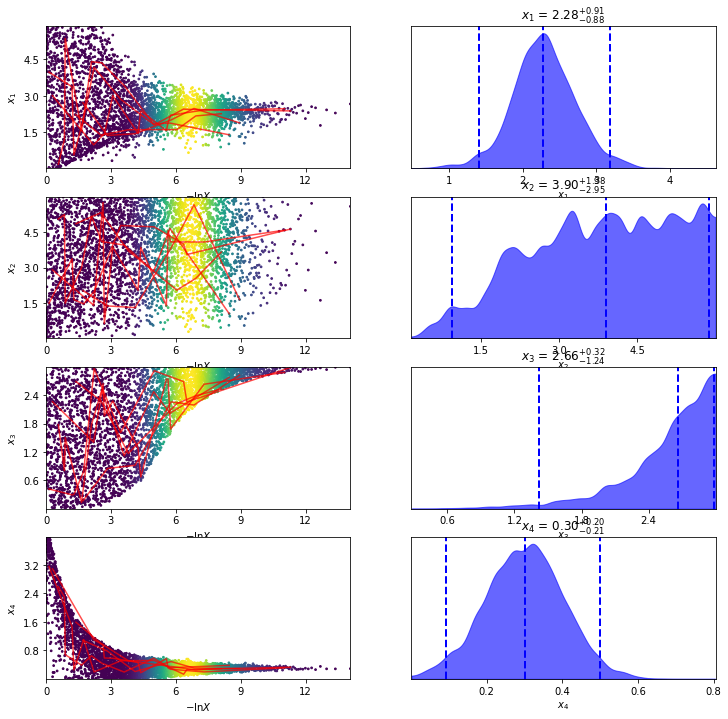

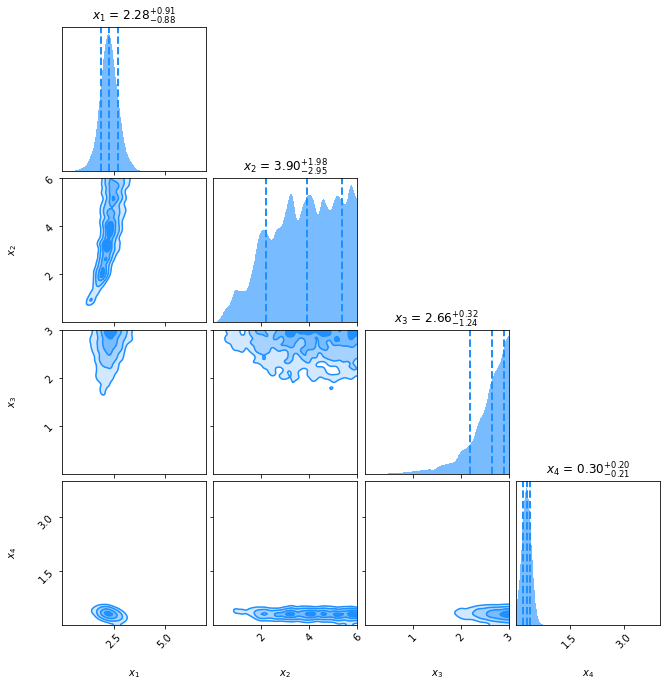

In [52]:
#Dynesty posterior results
#SF source

#Define parameter boundaries
dyn_param_bounds = [(0.0, 7.0), (0.0, 6.0), (0.0, 3.0), (0.0, 4.0)]

#plot
figs_posteriors = plot_dyn_results(dyn_results_sf, dyn_param_bounds)

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:640: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:641: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3219: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3251: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.d

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:640: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:641: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3219: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3251: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.d

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:640: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:641: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3219: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3251: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.d

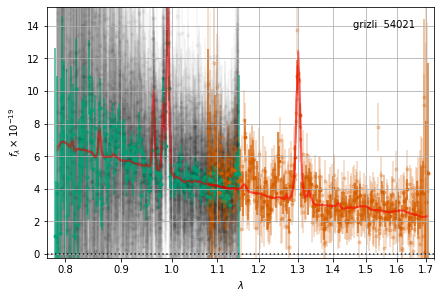

In [53]:
#Plot single best-fit model on top of data

fig_bestfit = best_fit_model(samples_equal_sf, mbeam_obj)


/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide b

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

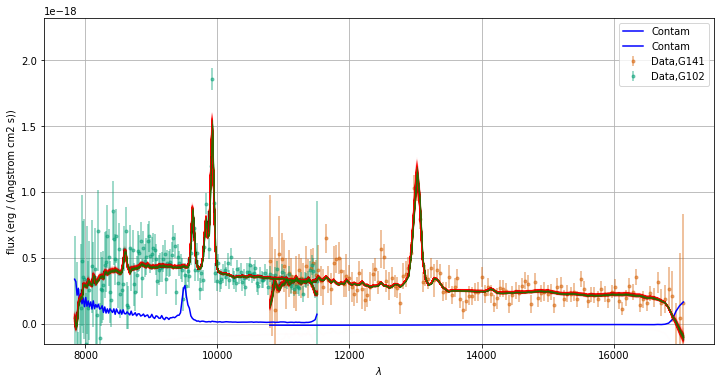

In [54]:
#Plot posterior SED with input and posterior fluxes

#number of draws to generate posterior SED from
nb_draws = 500

fig_posterior_SED = posterior_SED(samples_equal_sf, mbeam_obj, nb_draws)


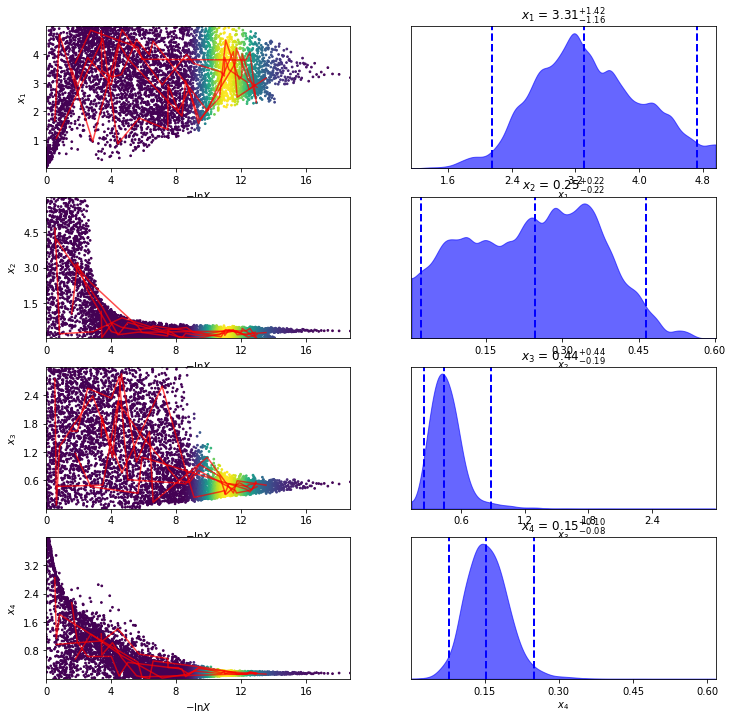

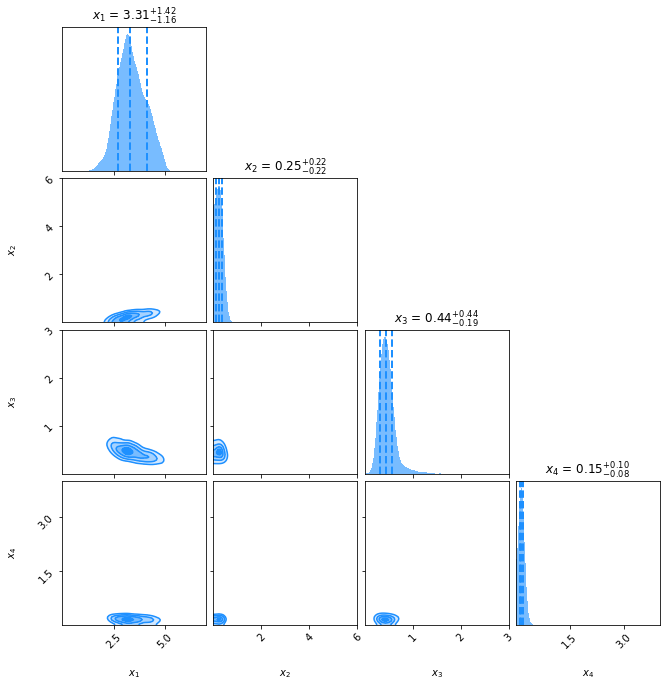

In [69]:
#Dynesty posterior results
#Q source

#plot
figs_posteriors = plot_dyn_results(dyn_results_q, dyn_param_bounds)

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:640: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:641: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3219: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3251: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.d

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:640: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:641: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3219: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3251: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.d

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:640: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:641: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3219: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3251: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.d

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:640: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/model.py:641: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3219: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.dev1365-py3.6-macosx-10.7-x86_64.egg/grizli/fitting.py:3251: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-1.0.d

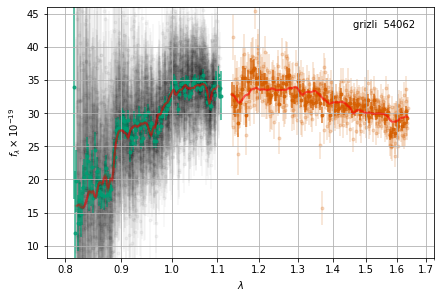

In [70]:
#Plot single best-fit model on top of data

fig_bestfit = best_fit_model(samples_equal_q, mbeam_obj)

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide b

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
/Users/gael/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by ze

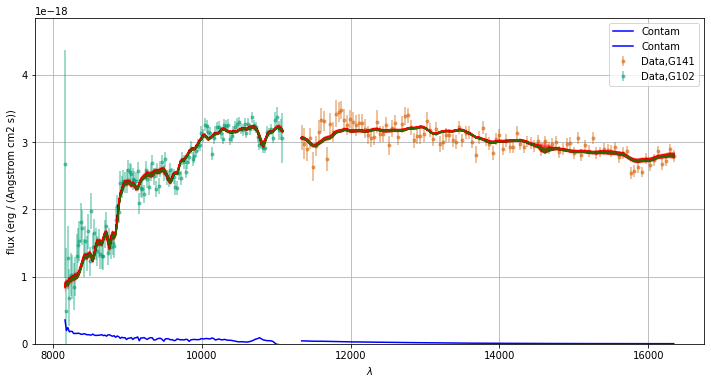

In [72]:
#Plot posterior SED with input and posterior fluxes

#number of draws to generate posterior SED from
nb_draws = 500

fig_posterior_SED = posterior_SED(samples_equal_q, mbeam_obj, nb_draws)



### &emsp;&emsp;b. Star-formation histories

In [218]:
#SF source

#Generate the star-formation histories for all the samples
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

#age, tau samples
time_array = np.linspace(0, 14, 500) #0=big-bang
age_samples = samples_equal_sf[:,0]
tau_samples = samples_equal_sf[:,1]

#Source redshift and age of universe at that redshift
redshift = z50_sf
ageU_z = cosmo.age(redshift).value
ageU_z_sf = ageU_z

#Age of Universe at the formation redshift of the source (samples)
ageU_zform_samples = ageU_z - age_samples
#shiffted time samples so that sfh is 0 at time of formation
t_samples = [time_array-ageU_zform_sample for ageU_zform_sample in ageU_zform_samples]

#SFH samples
sfh_samples_sf = []
for t, tau, age0 in zip(t_samples, tau_samples, ageU_zform_samples):
    sfh_sample = t * np.exp(-t/tau)
    sfh_sample[time_array<age0] = 0
    #normalize SFHs at source redshift,
    #so that all SFH samples have formed same amount of mass at redshift of obervation.
    norm = np.nansum(sfh_sample[time_array<ageU_z])
    sfh_sample = sfh_sample/norm
    sfh_samples_sf.append(sfh_sample)


In [219]:
#Q source

#Generate the star-formation histories for all the samples

#age, tau samples
age_samples = samples_equal_q[:,0]
tau_samples = samples_equal_q[:,1]

#Source redshift and age of universe at that redshift
redshift = z50_q
ageU_z = cosmo.age(redshift).value
ageU_z_q = ageU_z

#Age of Universe at the formation redshift of the source (samples)
ageU_zform_samples = ageU_z - age_samples
#shiffted time samples so that sfh is 0 at time of formation
t_samples = [time_array-ageU_zform_sample for ageU_zform_sample in ageU_zform_samples]

#SFH samples
sfh_samples_q = []
for t, tau, age0 in zip(t_samples, tau_samples, ageU_zform_samples):
    sfh_sample = t * np.exp(-t/tau)
    sfh_sample[time_array<age0] = 0
    #normalize SFHs at source redshift,
    #so that all SFH samples have formed same amount of mass at redshift of obervation.
    norm = np.nansum(sfh_sample[time_array<ageU_z])
    sfh_sample = sfh_sample/norm
    sfh_samples_q.append(sfh_sample)


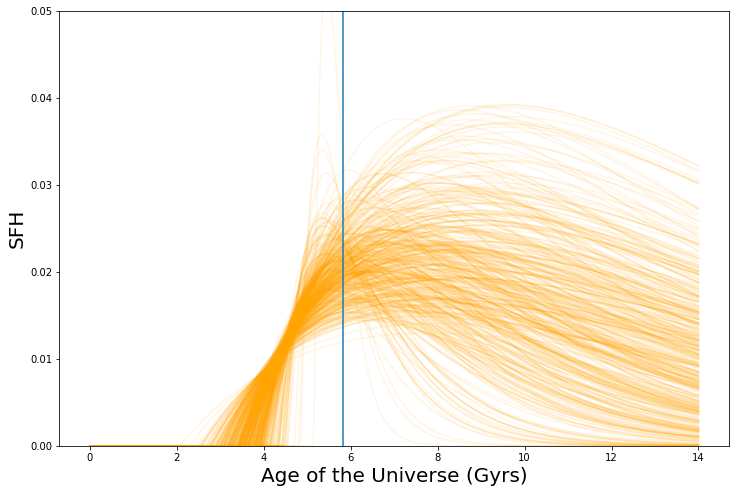

In [215]:
#Visualize SFH samples SF source

plt.figure(figsize=(12,8))
[plt.plot(time_array, sfh, '-', color='orange', alpha=0.1) for sfh in np.array(sfh_samples_sf)[np.random.randint(0,len(sfh_samples_sf), 500)]]
plt.axvline(ageU_z_sf)
plt.ylim(0,0.05)
plt.xlabel('Age of the Universe (Gyrs)', fontsize=20)
plt.ylabel('SFH', fontsize=20)
plt.show()

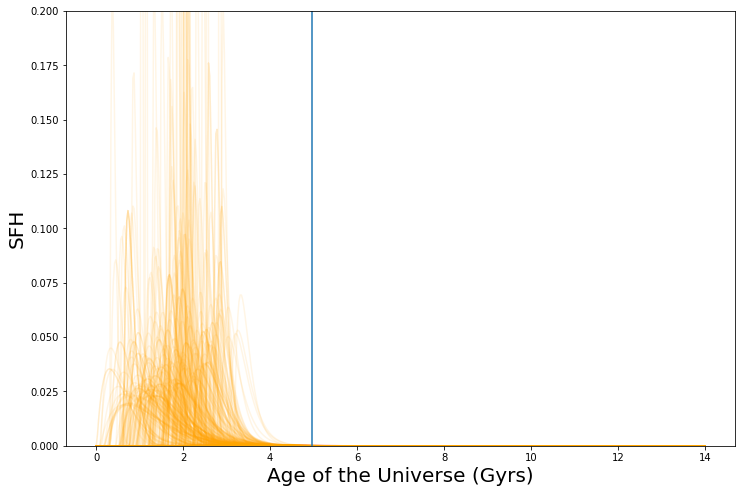

In [216]:
#Visualize SFH samples Q source

plt.figure(figsize=(12,8))
[plt.plot(time_array, sfh, '-', color='orange', alpha=0.1) for sfh in np.array(sfh_samples_q)[np.random.randint(0,len(sfh_samples_sf), 300)]]
plt.axvline(ageU_z_q)
plt.ylim(0,0.2)
plt.xlabel('Age of the Universe (Gyrs)', fontsize=20)
plt.ylabel('SFH', fontsize=20)
plt.show()

### SFHs -- Do percentiles/credible intervals make sense?

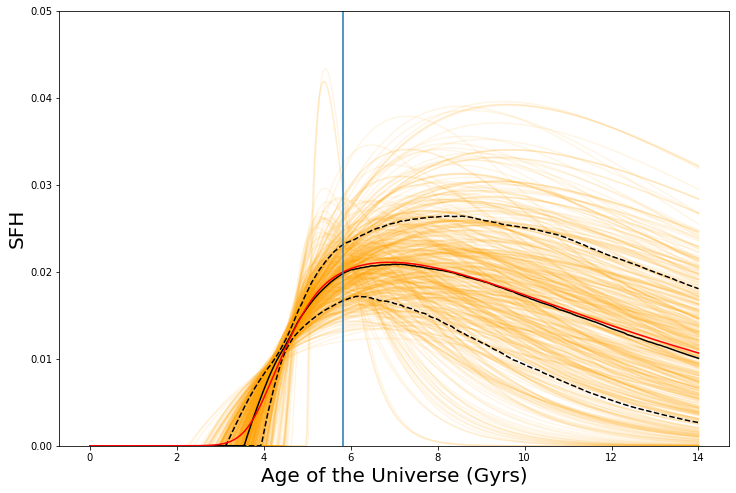

Integral 'median' SFH: 0.9933744955964249
Integral average SFH: 1.0000000000000004


In [220]:
#Percentiles
sfh_percentiles_sf = np.nanpercentile(sfh_samples_sf, [16, 50, 84], axis=0)

#Average
sfh_avg = np.average(sfh_samples_sf, axis=0)

#show
plt.figure(figsize=(12,8))
[plt.plot(time_array, sfh, '-', color='orange', alpha=0.1) for sfh in np.array(sfh_samples_sf)[np.random.randint(0,len(sfh_samples_sf), 500)]]
plt.plot(time_array, sfh_percentiles_sf[0], 'k--')
plt.plot(time_array, sfh_percentiles_sf[1], 'k-')
plt.plot(time_array, sfh_percentiles_sf[2], 'k--')
plt.plot(time_array, sfh_avg, '-', color='red')
plt.axvline(ageU_z_sf)
plt.ylim(0,0.05)
plt.xlabel('Age of the Universe (Gyrs)', fontsize=20)
plt.ylabel('SFH', fontsize=20)
plt.show()

#Both the median and average integrate to one up to source redshift
print("Integral 'median' SFH:", np.sum(sfh_percentiles_sf[1][time_array<ageU_z_sf]))
print("Integral average SFH:", np.sum(sfh_avg[time_array<ageU_z_sf]))


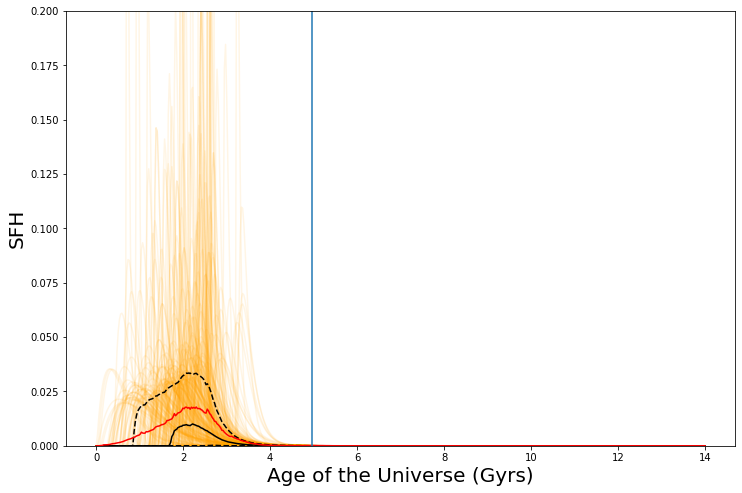

Integral 'median' SFH: 0.34092627621863664
Integral average SFH: 0.9999999999999991


In [253]:
#Percentiles
sfh_percentiles_q = np.nanpercentile(sfh_samples_q, [16, 50, 84], axis=0)

#Average
sfh_avg = np.average(sfh_samples_q, axis=0)

#show
plt.figure(figsize=(12,8))
[plt.plot(time_array, sfh, '-', color='orange', alpha=0.1) for sfh in np.array(sfh_samples_q)[np.random.randint(0,len(sfh_samples_q), 300)]]
plt.plot(time_array, sfh_percentiles_q[0], 'k--')
plt.plot(time_array, sfh_percentiles_q[1], 'k-')
plt.plot(time_array, sfh_percentiles_q[2], 'k--')
plt.plot(time_array, sfh_avg, '-', color='red')
plt.axvline(ageU_z_q)
plt.ylim(0,0.2)
plt.xlabel('Age of the Universe (Gyrs)', fontsize=20)
plt.ylabel('SFH', fontsize=20)
plt.show()

#The median doesn't integrate to one; the average does.
print("Integral 'median' SFH:", np.sum(sfh_percentiles_q[1][time_array<ageU_z_q]))
print("Integral average SFH:", np.sum(sfh_avg[time_array<ageU_z_q]))



### Comparing them all

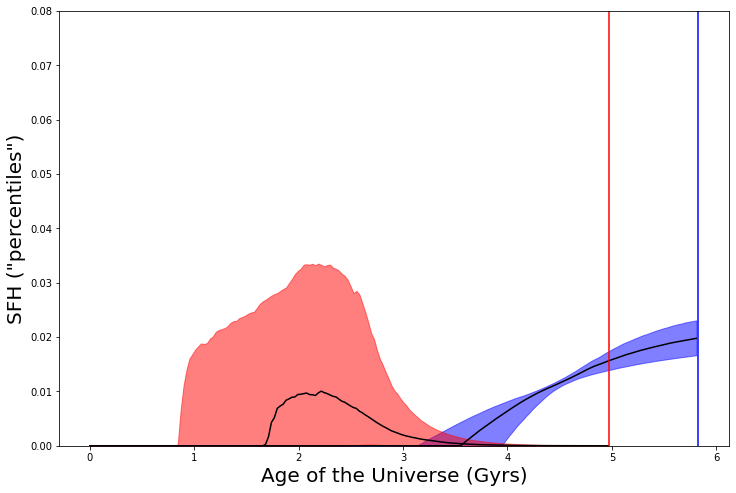

In [250]:
#Compare percentiles
plt.figure(figsize=(12,8))
#SF
plt.fill_between(time_array[time_array<ageU_z_sf], sfh_percentiles_sf[0][time_array<ageU_z_sf], sfh_percentiles_sf[2][time_array<ageU_z_sf], color='blue', alpha=0.5)
plt.plot(time_array[time_array<ageU_z_sf], sfh_percentiles_sf[1][time_array<ageU_z_sf], 'k-')
plt.axvline(ageU_z_sf, color='b')
#Q
plt.fill_between(time_array[time_array<ageU_z_q], sfh_percentiles_q[0][time_array<ageU_z_q], sfh_percentiles_q[2][time_array<ageU_z_q], color='red', alpha=0.5)
plt.plot(time_array[time_array<ageU_z_q], sfh_percentiles_q[1][time_array<ageU_z_q], 'k-')
plt.axvline(ageU_z_q, color='r')
plt.xlabel('Age of the Universe (Gyrs)', fontsize=20)
plt.ylabel('SFH ("percentiles")', fontsize=20)
plt.ylim(0,0.08)
plt.show()


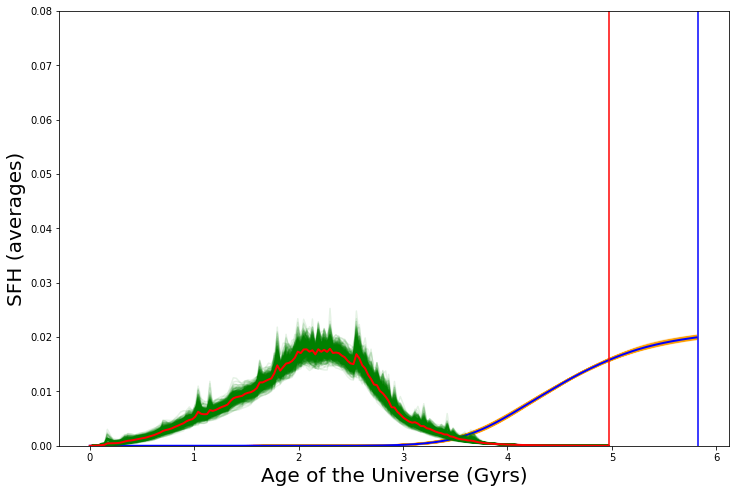

In [243]:
#Compare averages (with draws from bootstrap resamplings)

#bootstrap SF
bootres = bootstrap(np.array(sfh_samples_sf), bootnum=500, samples=500)
bootavg_sf = [np.average(boot, axis=0) for boot in bootres]

#bootstrap Q
bootres = bootstrap(np.array(sfh_samples_q), bootnum=500, samples=500)
bootavg_q = [np.average(boot, axis=0) for boot in bootres]

#Plots
plt.figure(figsize=(12,8))
#SF
[plt.plot(time_array[time_array<ageU_z_sf], bavg[time_array<ageU_z_sf], '-', color='orange', alpha=0.1) for bavg in bootavg_sf]
plt.plot(time_array[time_array<ageU_z_sf], np.average(sfh_samples_sf, axis=0)[time_array<ageU_z_sf], '-', color='blue', linewidth=2)
plt.axvline(ageU_z_sf, color='b')
#Q
[plt.plot(time_array[time_array<ageU_z_q], bavg[time_array<ageU_z_q], '-', color='green', alpha=0.1) for bavg in bootavg_q]
plt.plot(time_array[time_array<ageU_z_q], np.average(sfh_samples_q, axis=0)[time_array<ageU_z_q], '-', color='red', linewidth=2)
plt.axvline(ageU_z_q, color='r')
plt.xlabel('Age of the Universe (Gyrs)', fontsize=20)
plt.ylabel('SFH (averages)', fontsize=20)
plt.ylim(0,0.08)
plt.show()

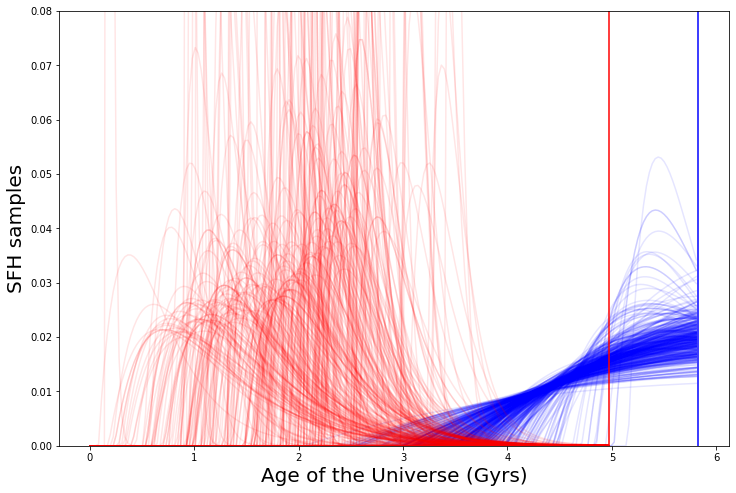

In [242]:
#Sample draws
plt.figure(figsize=(12,8))
#SF
[plt.plot(time_array[time_array<ageU_z_sf], sfh[time_array<ageU_z_sf], '-', color='blue', alpha=0.1) for sfh in np.array(sfh_samples_sf)[np.random.randint(0,len(sfh_samples_sf), 500)]]
plt.axvline(ageU_z_sf, color='b')
#Q
[plt.plot(time_array[time_array<ageU_z_q], sfh[time_array<ageU_z_q], '-', color='red', alpha=0.1) for sfh in np.array(sfh_samples_q)[np.random.randint(0,len(sfh_samples_q), 300)]]
plt.axvline(ageU_z_q, color='r')
plt.ylim(0,0.08)
plt.xlabel('Age of the Universe (Gyrs)', fontsize=20)
plt.ylabel('SFH samples', fontsize=20)
plt.show()

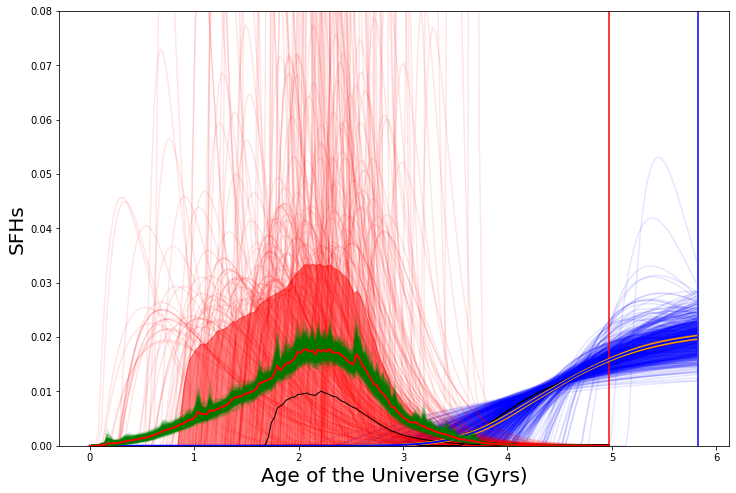

In [251]:
##
##
##

plt.figure(figsize=(12,8))
#SF
[plt.plot(time_array[time_array<ageU_z_sf], sfh[time_array<ageU_z_sf], '-', color='blue', alpha=0.1) for sfh in np.array(sfh_samples_sf)[np.random.randint(0,len(sfh_samples_sf), 500)]]
plt.axvline(ageU_z_sf, color='b')
#Q
[plt.plot(time_array[time_array<ageU_z_q], sfh[time_array<ageU_z_q], '-', color='red', alpha=0.1) for sfh in np.array(sfh_samples_q)[np.random.randint(0,len(sfh_samples_q), 300)]]
plt.axvline(ageU_z_q, color='r')

#SF
plt.fill_between(time_array[time_array<ageU_z_sf], sfh_percentiles_sf[0][time_array<ageU_z_sf], sfh_percentiles_sf[2][time_array<ageU_z_sf], color='blue', alpha=0.5)
plt.plot(time_array[time_array<ageU_z_sf], sfh_percentiles_sf[1][time_array<ageU_z_sf], 'k-')
#Q
plt.fill_between(time_array[time_array<ageU_z_q], sfh_percentiles_q[0][time_array<ageU_z_q], sfh_percentiles_q[2][time_array<ageU_z_q], color='red', alpha=0.5)
plt.plot(time_array[time_array<ageU_z_q], sfh_percentiles_q[1][time_array<ageU_z_q], 'k-', linewidth=1)

#SF
[plt.plot(time_array[time_array<ageU_z_sf], bavg[time_array<ageU_z_sf], '-', color='orange', alpha=0.1) for bavg in bootavg_sf]
plt.plot(time_array[time_array<ageU_z_sf], np.average(sfh_samples_sf, axis=0)[time_array<ageU_z_sf], '-', color='blue', linewidth=2)
#Q
[plt.plot(time_array[time_array<ageU_z_q], bavg[time_array<ageU_z_q], '-', color='green', alpha=0.1) for bavg in bootavg_q]
plt.plot(time_array[time_array<ageU_z_q], np.average(sfh_samples_q, axis=0)[time_array<ageU_z_q], '-', color='red', linewidth=2)


plt.ylim(0,0.08)
plt.xlabel('Age of the Universe (Gyrs)', fontsize=20)
plt.ylabel('SFHs', fontsize=20)
plt.show()

Suggested conclusion --> only use samples to visualize SFHs.\
Done!

---

Gaël Noirot,\
Postdoctoral Fellow,\
Saint Mary's University,\
10 March, 2022